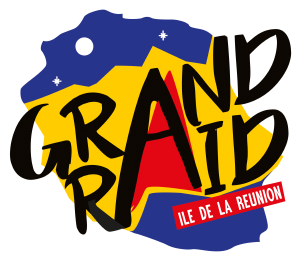

### Scraping source

For this data exploration project we used the official race results website for the 2021 edition linked below

https://www.grandraid-reunion.com/francais/resultats/?annee=2021&course=GR

### 1. Scraping the list of athletes who participated in the main race

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import os
import pandas as pd

def scrape_results_urls(main_url):
    """Builds a list of links for all athletes taking part in the race"""
    
    # starting time, to keep track of execution time
    t0 = time.time()
    
    # Setting options for selenium
    options = Options()
    options.add_argument('--headless') 
    options.add_argument('--blink-settings=imagesEnabled=false')
    driver = webdriver.Chrome(options=options)

    # Scraping the page source containing the list of all athletes and saving it locally
    driver.get(main_url)
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'result-list')))
    html = driver.page_source
    file_object = open('./results.html', "w")
    file_object.write(html)
    file_object.close()

    # Initializing an empty list that will contain all the individual urls    
    results_urls = []
    
    
    # parsing the page source for all individual urls
    parsed_content = BeautifulSoup(html, 'lxml')
    res_list = parsed_content.find("ol", {"class": "result-list"})
    individual_results_list = res_list.findAll("li", {"class": "bold"})
    for result in individual_results_list:
        try:
            href = result.find("a").get("href")
            results_urls.append(href)
        except:
            pass
    
    # Saving the dataset locally to a csv file
    df = pd.DataFrame(result_urls)
    df.to_csv('./result_urls.csv', index=False)
    number_of_links = len(df)
    duration = int(time.time() - t0)
    print(f"process completed in {duration} seconds and generated {number_of_links} listings urls")

    return results_urls

if __name__ == "__main__":
    link = "https://www.grandraid-reunion.com/francais/resultats/?annee=2021&course=GR"
    result_urls = scrape_results_urls(link)
    print(result_urls)
    print(len(result_urls))

### 2. Scraping the data for each athlete

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import os
import pandas as pd

def scrape_results_urls():
    """Builds links for all search pages for a given location"""
    
    # starting time, to keep track of execution time
    t0 = time.time()
    
    # Retrieve the list of individual URLs
    urls_df=pd.read_csv('./result_urls.csv')
    tot=len(urls_df)

    # creating a list to keep track of failed url scraping
    errors=[]
    
    # scraping the html for each individual athlete
    for i,row in urls_df.iterrows():
        url=row[0]
        try:
            time.sleep(3)
            save_individual_htmls(url, i)
            print(f'{i}/{tot} scraping done')
        except Exception as e:
            print("ERROR : " + str(e))
            print(f'{i}/{tot} failed')
            errors.append(i)

            
    # print useful execution information at the end
    duration = int(time.time() - t0)
    print(f"process completed in {duration} seconds and {len(errors)} urls failed")
    print(errors)

    return errors


def save_individual_htmls(url,num):
   
    # Setting options for selenium
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--blink-settings=imagesEnabled=false')
    driver = webdriver.Chrome(options=options)

    # Scraping the URL
    driver.get(url)
    WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'resume')))

    # Saving the page source locally. A tricky situation here as some results had sepcial caracters 
    # and needed to be utf-8 encoded
    try:
        file_object = open(f'./results/{num}.html', "w")
    except:
        file_object = open(f'./results/{num}.html', "w", encoding="utf-8")
    html = driver.page_source
    file_object.write(html)
    file_object.close()
    
    return

if __name__ == "__main__":
    result_urls = scrape_results_urls()

### 3. Parsing individual data to create the datasets

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import os
from os import listdir
from os.path import isfile, join


def extract_element_data(num):
    """Extracts data from a specified HTML element"""

    # try / except to catch different encodings 
        try:
            file_object = open(f'./results/{i}.html', "r")
            parsed_content = BeautifulSoup(file_object, 'lxml')

        except:
            file_object = open(f'./results/{i}.html', "r", encoding="utf-8")
            parsed_content = BeautifulSoup(file_object, 'lxml')

        
    # Parsing html with beautifulsoup
    parsed_content = BeautifulSoup(file_object, 'lxml')

    # Feature dossard, nom, prénom
    cat = parsed_content.find("div", {"class": "cat"}).getText(strip=True)
    cat = cat.replace('Infos coureurDossard ', '')
    cat = cat.replace('Infos coureurPalmarèsDossard ', '')
    cat = cat.split('   Diagonale des fous - ')
    num_dossard = int(cat[0])
    pnom = parsed_content.find("span", {"class": "pnom"}).getText()
    nom = parsed_content.find("span", {"class": "nom"}).getText()

    # initializing a athlete list 
    athlete = [num_dossard, pnom, nom]
    
    
    # features 'genre', 'cat', 'club', 'nationalité', 'ville', 'pays','etat', 
                        'vit_moy'
    personal_info = parsed_content.find("div", {"class": "col2"})
    tds = personal_info('td')
    for i, td in enumerate(tds):
        if i in [1, 3, 5, 7, 9, 11]:
            athlete.append(td.getText(strip=True))

    # features different for women (global rankin and women ranking) and men    
    # features 'class_gen', 'class_F','class_cat', 'arrivée', 'tps_course',
    table_resume = parsed_content.find("table", {"class": "resume"})
    resume_rows = table_resume('tr')
    for i, row in enumerate(resume_rows):
        for j, td in enumerate(row('td')):
            athlete.append(td.getText(strip=True))
    if athlete[3]=='Femme':
        athlete[9] = athlete[9].replace('Etat', '')
        athlete[10] = int(athlete[10][-1])
        athlete[11] = int(athlete[11][-1])
        athlete[12] = int(athlete[12][-1])
        athlete[13] = athlete[13].replace('Dernier pointVe. ', '')[:5]
        if athlete[9] != "Arrêté":
            athlete[14] = athlete[14].replace('Temps de course', '')
            athlete[15] = athlete[15].replace('Vitesse', '')
            athlete[15] = athlete[15].replace(' km/h', '')
            athlete[15] = float(athlete[15].replace(',', '.'))
    else:
        athlete[9] = athlete[9].replace('Etat', '')
        athlete[10] = int(athlete[10][-1])
        athlete[11] = int(athlete[11][-1])
        athlete[12] = athlete[12].replace('Dernier pointVe. ', '')[:5]
        if athlete[9]!="Arrêté":
            athlete[13] = athlete[13].replace('Temps de course', '')
            athlete[14] = athlete[14].replace('Vitesse', '')
            athlete[14] = athlete[14].replace(' km/h', '')
            athlete[14] = float(athlete[14].replace(',', '.'))
            athlete.insert(11,'')

    # Perf num_dossard, Point_de_passage, Vitesse, Class., Jour/heure_de_passage, tps_course
    table_tpasse = parsed_content.find("table", {"class": "tpass"})
    rows = table_tpasse('tr')
    rows_content = []
    for i, row in enumerate(rows):
        list = []
        if i == 0:
            for th in row('th'):
                if th.getText() == '\n\t\t\t\t\t\t\tTemps de course\t\t\t\t\t\t\t':
                    list.append('Temps de course')
                else:
                    list.append(th.getText())
                # print(list )
            rows_content.append(list)
        else:
            list = [num_dossard]
            for j, td in enumerate(row('td')):
                if j == 0:
                    list.append(td.find('a').getText())
                else:
                    list.append(td.getText(strip=True))
            rows_content.append(list)

    perf = rows_content[1:]

    return athlete, perf


def parse_individuals():
    directory_path = os.getcwd()
    results_directory = join(directory_path, 'results')
    file_list = [f for f in listdir(results_directory) if isfile(join(results_directory, f))]
    target_directory = join(directory_path, 'parsed_results')
    datasets_directory = join(directory_path, 'datasets')

    athletes_columns = ['num_dossard', 'pname', 'name', 'genre', 'cat', 'club', 'nationalité', 'ville', 'pays','etat', 'class_gen', 'class_F','class_cat', 'arrivée', 'tps_course',
                        'vit_moy' ]

    performances_columns = ['num_dossard', 'Point_de_passage', 'Vitesse', 'Class.', 'Jour/heure_de_passage',
                            'tps_course']

    athletes = []
    performances = []
    errors=[]
    for i in range(len(file_list)):
        try:
            athlete, performance = extract_element_data(i)
            athletes.append(athlete)
            for lign in performance:
                performances.append(lign)
        except Exception as e:
            print("ERROR : " + str(e))
            print(i)
            errors.append(i)


    # Save Athletes dataset to CSV
    athletes_df = pd.DataFrame(athletes)
    athletes_df.columns = athletes_columns
    athletes_df.to_csv(join(datasets_directory, 'athletes.csv'), header=True, index=False)
    print(athletes_df.head())

    # Save Performancet dataset to CSV
    performances_df = pd.DataFrame(performances)
    performances_df.columns = performances_columns
    performances_df.to_csv(join(datasets_directory, 'performances.csv'), header=True, index=False)
    print(performances_df.head())

    # Print errors
    print(errors)
    return


if __name__ == "__main__":
    parse_individuals()

### 4. stations dataset

There are several resupply stations along the way that we can use to define segements with distances, D+ (ascending elevation), altitude and GPS coordinates. Those pieces of information were garner manually.

In [ ]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

def create_etapes_dataset():
    directory_path = os.getcwd()
    datasets_directory = join(directory_path, 'datasets')

    columns = ['NOM ETAPE','ETAPE PREC.','NUM ETAPE','ALTITUDE','DIST. DEPUIS LE DÉPART (KM)','DIST. DEPUIS PRECEDENT (KM)','D+ DEPUIS LE DÉPART (M)','D+ DEPUIS DOMAINE PRECEDENT (M)','LATITUDE','LONGITUDE']

    etapes=[
        ['ST PIERRE RAVINE BLANCHE','',0,3,0,0,0,0,-21.334486634175683, 55.46257224095708],
        ['DOMAINE VIDOT', 'ST PIERRE RAVINE BLANCHE',1, 650, 14.6, 14.6,663, 663,-21.312117904695366, 55.5485616153416 ],
        ['NOTRE DAME DE LA PAIX', 'DOMAINE VIDOT',2, 1602, 24.9, 10.4, 1687, 1024,-21.248885092968194, 55.5989935020165],
        ['PARKING AIRE NEZ DE BOEUF', 'NOTRE DAME DE LA PAIX',3, 2018, 38.8, 13.9, 2440, 753,-21.204995900932236, 55.61679541220081],
        ['MARE À BOUE', 'PARKING AIRE NEZ DE BOEUF',4, 1601, 49.2, 10.4, 2511, 71,-21.160180006341562, 55.570757297488704],
        ['CILAOS (STADE)', 'MARE À BOUE',5, 1207, 66.1, 16.9, 3336, 825,-21.13501902519813, 55.47481625251336],
        ['SENTIER TAÏBIT (DÉBUT)', 'CILAOS (STADE)',6, 1262, 72.7, 6.6, 3833, 497,-21.116965104203345, 55.45064667616225],
        ['MARLA', 'SENTIER TAÏBIT (DÉBUT)',7, 1614, 78.7, 6.0, 4665, 832,-21.102651161664944, 55.433699698316744],
        ['PLAINE DES MERLES', 'MARLA', 8,1809, 86.3, 7.6, 5161, 496,-21.073755786845823, 55.451307726678124],
        ['SENTIER SCOUT', 'PLAINE DES MERLES',9, 1632, 88.4, 2.1, 5174, 13,-21.052765042179438, 55.45441797694862],
        ['ILET À BOURSE', 'SENTIER SCOUT', 10,888, 96.4, 8.0, 5389, 215,-21.04202884991624, 55.427462873842174],
        ['GD PLACE LES BAS / ÉCOLE', 'ILET À BOURSE',11, 665, 99.7, 3.3, 5534, 145,-21.038496593930127, 55.40971669195356],
        ['PLATEAU DE CERF - ROCHE PLATE', 'GD PLACE LES BAS / ÉCOLE',12, 1253, 108, 8.3, 6653, 1119,-21.073617934534838, 55.40078280783869],
        ['ILET DES ORANGERS', 'PLATEAU DE CERF - ROCHE PLATE',13, 983, 113.5, 5.4, 6969, 316,-21.042491837243197, 55.39236130384289],
        ['DEUX BRAS', 'ILET DES ORANGERS',14, 258, 121.9, 8.4, 7258, 289,-21.003386089319438, 55.39419904599862],
        ['DOS D\'ANE', 'DEUX BRAS',15, 258, 126.6, 4.8, 7963, 705,-20.98057473820627, 55.37216110851838],
        ['CHEMIN RATINAUD', 'DOS D\'ANE',16, 467, 130, 3.4, 7968, 5,-20.963347037690994, 55.35869896813858],
        ['LA POSSESSION', 'CHEMIN RATINAUD',17, 3, 138.8, 8.7, 8151, 183,-20.92652865916658, 55.33758113789248],
        ['GRANDE CHALOUPE', 'LA POSSESSION',18, 10, 146.1, 7.3, 8518, 367,-20.89554066710821, 55.37737164215647],
        ['LE COLORADO', 'GRANDE CHALOUPE',19, 871, 155.5, 9.5, 9356, 838,-20.906137318196727, 55.42508680643403],
        ['ST DENIS LA REDOUTE', 'LE COLORADO',20, 53, 160.2, 4.7, 9377, 21,-20.884480141429272, 55.441974429782874],
    ]

    etapes_df = pd.DataFrame(etapes)
    etapes_df.columns = columns
    etapes_df.to_csv(join(datasets_directory, 'etapes.csv'), header=True, index=False)

    return

if __name__ == "__main__":
    create_etapes_dataset()

All codes and data are available here : https://github.com/afrancoisdata/GRR